#Task 1

## Importing dependencies
We used the following libraries in the first task:
- `pandas` to manipulate the data
- `scikit-learn` for imputing and scaling the data
- `seaborn` and `matplotlib` for visualization.

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Data exploration
Let's load the training dataset from the corresponding .csv file.
Since we know that the columns represent the mean/standard deviation of the positions and angles of the 60 points, respectively, followed by the label name and code, let us rename the columns accordingly to allow for easier reading.

In [ ]:
def load_data():
  training_data = pd.read_csv('train-final.csv', header=None)
  test_data = pd.read_csv('test-final.csv', header=None)

  name_mappings = {
      # Feature columns
      **{i:f'positions_mean_{i}' for i in range(60)},
      **{i:f'positions_std_{i}' for i in range(60, 120)},
      **{i:f'angles_mean_{i}' for i in range(120, 180)},
      **{i:f'angles_std_{i}' for i in range(180, 240)},
      # Label columns
      **{240: 'label_name', 241: 'label_code'},
  }

  training_data.rename(name_mappings, axis=1, inplace=True)
  training_feature_columns = training_data.columns[:-2]

  training_features = training_data[training_feature_columns]
  training_labels = training_data.label_name
  training_codes = training_data.label_code

  test_data.rename(name_mappings, axis=1, inplace=True)
  test_feature_columns = test_data.columns[:-2]

  test_features = test_data[test_feature_columns]
  test_labels = test_data.label_name

  return training_features, training_labels, training_codes, test_features, test_labels


training_features, training_labels, training_codes, test_features, test_labels = load_data()

Let's show some of the data

In [ ]:
training_features.head()

,positions_mean_0,positions_mean_1,positions_mean_2,positions_mean_3,positions_mean_4,positions_mean_5,positions_mean_6,positions_mean_7,positions_mean_8,positions_mean_9,...,angles_std_230,angles_std_231,angles_std_232,angles_std_233,angles_std_234,angles_std_235,angles_std_236,angles_std_237,angles_std_238,angles_std_239
0,-0.479730,0.726079,2.403713,-0.481913,0.540689,2.455865,-0.646274,0.406351,2.428461,-0.312905,...,0.403147,0.422235,0.730551,0.367526,0.520040,0.493564,0.485049,0.477886,0.607874,0.441320
1,0.051888,0.646871,2.409750,0.060117,0.451912,2.449198,-0.106647,0.344324,2.461468,0.183852,...,0.458585,0.365385,0.428723,0.571661,0.431776,0.279627,0.595978,0.389501,0.241849,0.617291
2,-0.002692,0.624926,2.240212,0.018586,0.435987,2.269613,-0.152985,0.336314,2.305371,0.164105,...,0.556154,0.449078,0.537268,0.488480,0.540547,0.542650,0.430114,0.542999,0.454954,0.479623
3,-0.029336,0.664426,2.443440,-0.023426,0.480809,2.451577,-0.203417,0.353489,2.506273,0.119183,...,0.458485,0.420331,0.713397,0.387092,0.439498,0.417769,0.554555,0.498407,0.565789,0.455313
4,0.065604,0.639172,2.377587,0.069247,0.447377,2.405972,-0.092707,0.339007,2.368022,0.231172,...,0.498700,0.280299,0.671461,0.475014,0.401192,0.372539,0.578720,0.446630,0.580236,0.460550


In [ ]:
test_features.head()

,positions_mean_0,positions_mean_1,positions_mean_2,positions_mean_3,positions_mean_4,positions_mean_5,positions_mean_6,positions_mean_7,positions_mean_8,positions_mean_9,...,angles_std_230,angles_std_231,angles_std_232,angles_std_233,angles_std_234,angles_std_235,angles_std_236,angles_std_237,angles_std_238,angles_std_239
0,-0.332255,0.672471,2.450465,-0.323645,0.486062,2.526748,-0.483695,0.370296,2.534973,-0.172186,...,0.348333,0.426959,0.604953,0.464157,0.751404,0.467516,0.306133,0.521694,0.546094,0.439480
1,-0.089784,0.656778,2.431880,-0.079363,0.467939,2.429239,-0.193909,0.349866,2.329680,0.081013,...,0.482754,0.456633,0.596048,0.461552,0.557319,0.373754,0.515013,0.413323,0.491261,0.530069
2,-0.427810,0.699557,2.347763,-0.444873,0.530140,2.433568,-0.610365,0.402565,2.398841,-0.264254,...,0.582908,0.412314,0.777705,0.318174,0.532617,0.476989,0.487606,0.604556,0.489667,0.433812
3,-0.089790,0.694279,2.428455,-0.072881,0.520537,2.496676,-0.255747,0.404209,2.520148,0.115363,...,0.409941,0.328799,0.551472,0.498960,0.313094,0.450005,0.581886,0.409794,0.377352,0.578679
4,-0.387741,0.540410,2.399926,-0.406310,0.361768,2.459448,-0.576004,0.262814,2.457772,-0.256852,...,0.348730,0.311284,0.684091,0.457543,0.446787,0.499285,0.512345,0.366741,0.468337,0.526775


How many different labels do we have in the training dataset?

In [ ]:
number_of_classes = training_labels.nunique()
number_of_classes

30

Now let's take a look at how many occurrences we have of each label.

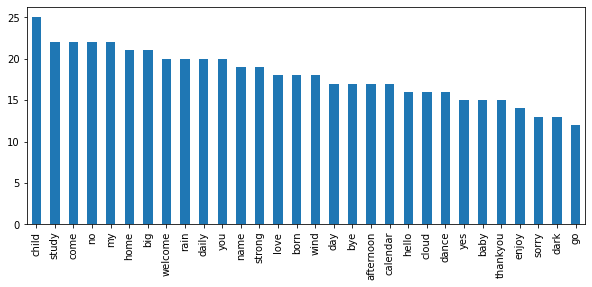

In [ ]:
training_labels.value_counts().plot(kind='bar', figsize=(10, 4))

We can see that `child` is the most common label in the training dataset and that `go` is the least common label.

Now let's look for columns that have missing values. The missing values are in the following columns (along with the missing value count):


In [ ]:
# Look for columns that have missing values
columns_null_sum = training_features.isnull().sum()
columns_with_nulls = columns_null_sum[columns_null_sum > 0]

print(
    "Total amount of missing values in the dataframe:", 
    training_features.isnull().sum().sum()
)
print(
    "Missing values in the following column indexes (and missing value count):"
)
print(columns_with_nulls)

Total amount of missing values in the dataframe: 21
Missing values in the following column indexes (and missing value count):
positions_mean_7     4
positions_mean_8     4
positions_mean_9     4
positions_mean_14    3
positions_mean_15    3
positions_mean_16    3
dtype: int64


Some classifiers are more sensitive to the range, mean & outliers of the features, such as linear regression models, for example.
In order to be able to train a wide range of classifiers and compare them, we will need to preprocess the data for scaling and outlier treatment.

Let's see if the dataset also contains outliers. There are quite a few way to detect outliers (Source:
[Outlier detection methods in Scikit-Learn](https://scikit-learn.org/stable/modules/outlier_detection.html)):
- Isolation forest
- Local outlier factor
- One-class support vector machine (SVM)
- Elliptic envelope

We start by doing a boxplot for all features to get a visual indication of the outlier situation.

([<matplotlib.axis.XTick at 0x7fee0b60bad0>], [Text(0, 0, '')])

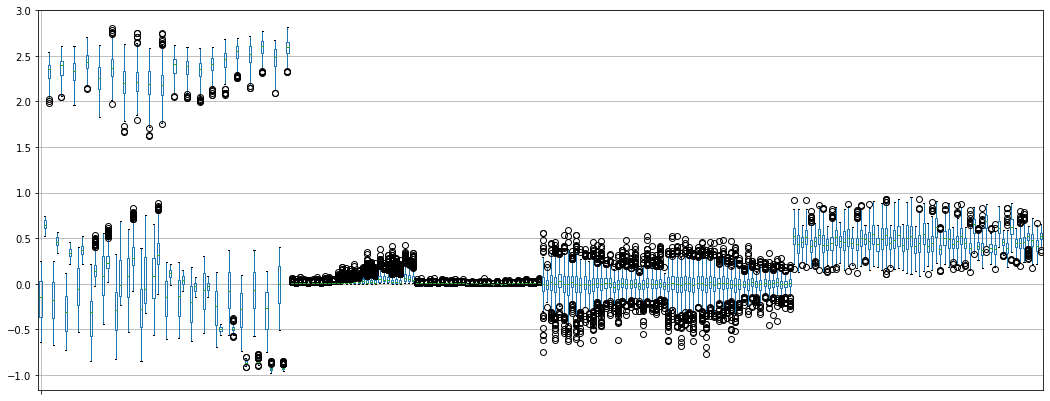

In [ ]:
training_features.boxplot(figsize=(18,7))
plt.xticks([1], [''])

Based on the boxplot, there appears to be many columns with outliers. Many classifiers, e.g. linear classifiers like Logistic Regression will not handle outliers well, so we need to find a way to handle also outliers.

## Methods

### Outliers

As we saw in the boxplot above, there are many columns with outliers. And while there are many methods to detect outliers,let's begin with just identifying the **values** that are farthest from the mean. 

A simple approach is to identify the values that lie outside of 3$\sigma$ (that is, three times the standard deviation) as outliers, and drop the rows that have at least one outlier. Let's give it a try.

In [ ]:
#training_features_outliers_marked = training_features[abs(training_features) <= 3]
from scipy import stats

training_features_outliers_marked = training_features[
    np.abs(stats.zscore(training_features.fillna(training_features.mean()))) < 3
]

In [ ]:
training_features_outliers_marked.head()

,positions_mean_0,positions_mean_1,positions_mean_2,positions_mean_3,positions_mean_4,positions_mean_5,positions_mean_6,positions_mean_7,positions_mean_8,positions_mean_9,...,angles_std_230,angles_std_231,angles_std_232,angles_std_233,angles_std_234,angles_std_235,angles_std_236,angles_std_237,angles_std_238,angles_std_239
0,-0.479730,0.726079,2.403713,-0.481913,0.540689,2.455865,-0.646274,0.406351,2.428461,-0.312905,...,0.403147,0.422235,0.730551,0.367526,0.520040,0.493564,0.485049,0.477886,0.607874,0.441320
1,0.051888,0.646871,2.409750,0.060117,0.451912,2.449198,-0.106647,0.344324,2.461468,0.183852,...,0.458585,0.365385,0.428723,0.571661,0.431776,0.279627,0.595978,0.389501,0.241849,0.617291
2,-0.002692,0.624926,2.240212,0.018586,0.435987,2.269613,-0.152985,0.336314,2.305371,0.164105,...,0.556154,0.449078,0.537268,0.488480,0.540547,0.542650,0.430114,0.542999,0.454954,0.479623
3,-0.029336,0.664426,2.443440,-0.023426,0.480809,2.451577,-0.203417,0.353489,2.506273,0.119183,...,0.458485,0.420331,0.713397,0.387092,0.439498,0.417769,0.554555,0.498407,0.565789,0.455313
4,0.065604,0.639172,2.377587,0.069247,0.447377,2.405972,-0.092707,0.339007,2.368022,0.231172,...,0.498700,0.280299,0.671461,0.475014,0.401192,0.372539,0.578720,0.446630,0.580236,0.460550


Number of rows left 250


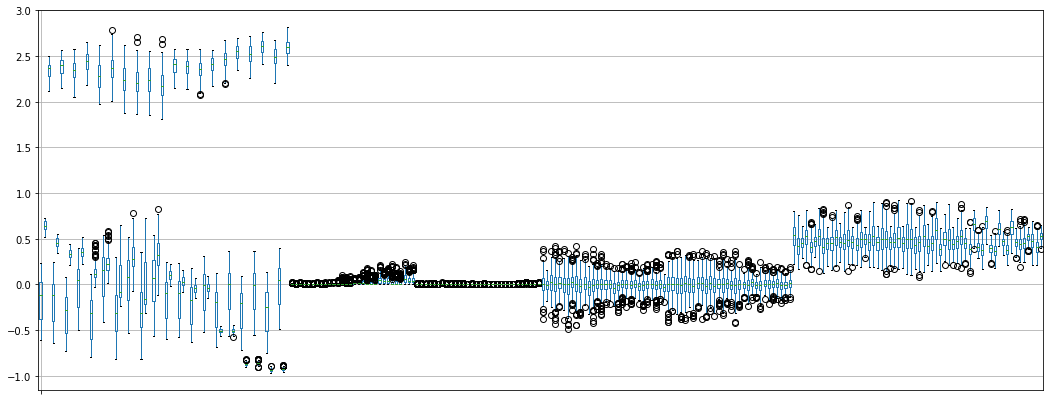

In [ ]:
training_features_outliers_removed = training_features_outliers_marked.dropna()
training_features_outliers_removed.boxplot(figsize=(18,7))
plt.xticks([1], [''])
print("Number of rows left", training_features_outliers_removed.shape[0])

The boxplot now looks better, except for the second part (columns 60 to 120), which is `positions_std_i`.
We can also see that if we remove all the rows with at least one detected outlier, we are left with less than half of the original data! This is due to the large number of features.

We need another method for this dataset, let's instead cap the outliers to 3 sigma.

In [ ]:
def pipeline_outliers(df, std_cap=3):
  df = df.copy()

  for column in df.columns:

    mean = df[column].mean(skipna = True)
    std = df[column].std(skipna = True)
    
    df[column] = np.clip(df[column], -(mean + std_cap*std), mean + std_cap*std)

  return df

([<matplotlib.axis.XTick at 0x7fee08834990>], [Text(0, 0, '')])

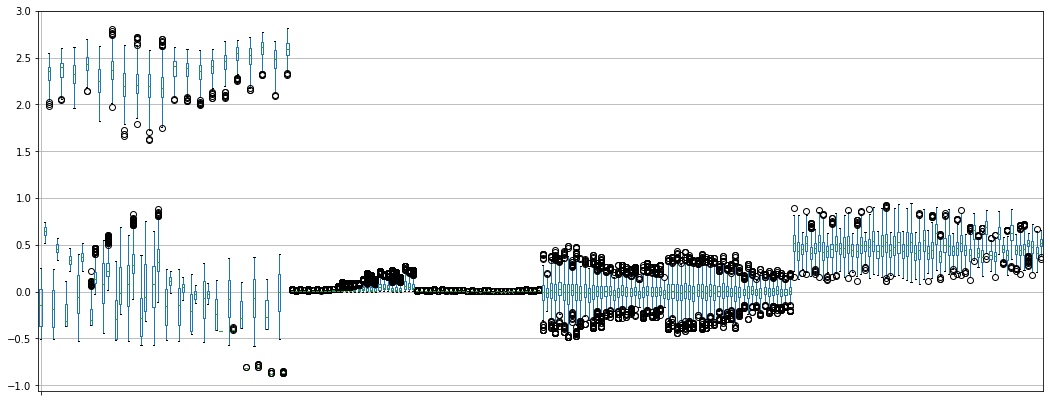

In [ ]:
df = pipeline_outliers(training_features)
df.boxplot(figsize=(18,7))
plt.xticks([1], [''])

### Missing data

As we saw above, there are 6 columns that have missing values (3 or 4 missing values each). Many classifiers do not handle missing values directly, such as Logistic Regression and SVM, for example. As such we need to find a way to manage the missing values.

There are many different ways of handling missing values and we will explore a few of them here. To get started, let's examine the features/columns that contain missing data. The two visualizations chosen for each of the features/columns are:

- *Histogram* - This will give a good indication of the distribution, for example if it appears to be normal.
- *Boxplot* - We get some additional information from the boxplot showing the median, quartiles as well as outliers.

Let's plot the distributions for the columns with missing data:

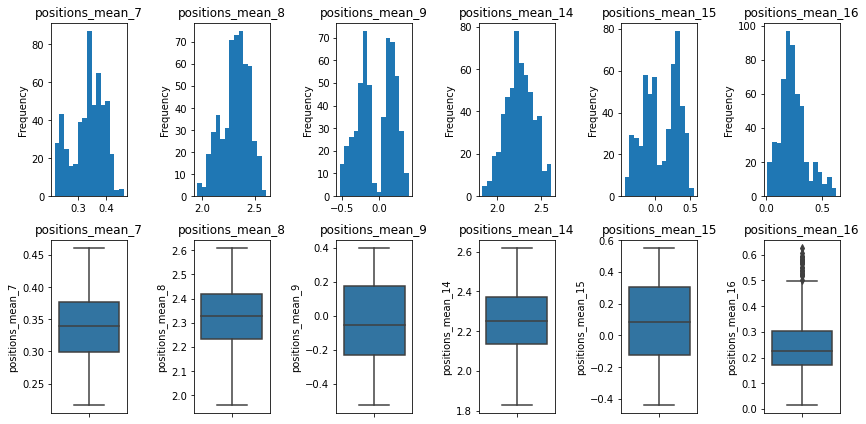

In [ ]:
def plot_distributions_for_columns(dataframe, columns):
    # Plot distributions for each of the columns that have missing values
    figure, axes = plt.subplots(2, len(columns), figsize=(12, 6))

    for index, column in enumerate(columns):
        # plot a histogram of the column for the first row
        dataframe[column].plot(
            kind='hist', ax=axes[0, index], title=column, bins=15
        )
        # Do a box plot as well
        sns.boxplot(y=dataframe[column], ax=axes[1, index]).set_title(column)

    plt.tight_layout()


plot_distributions_for_columns(training_features, columns_with_nulls.index)

The distributions are quite different, which mean we may need different imputation techniques for each column.
For example, the columns `positions_mean_9` and `positions_mean_15` are clearly not normal distributions and replacing missing values with the mean would likely not be ideal.
For instance in the case of `positions_mean_9` the mean is close to 0 where few other samples are, moreover this feature may even need to be split into two separate features as it appears to be the combination of two gaussian distributions.

Also, we do not know if the missing values themselves have a significance, i.e. we might want to create a separate column to indicate that a missing value is present or not. There are relatively few rows that have missing values, though, that may limit the usefulness of this technique and usefulness will also depend on the classifier used in the end.

For now, we will implement support for the following imputation strategies:
- Replacing with **mean**
- **Drop the rows** containing at least one missing value
- **K-Nearest Neighbour (KNN)** imputation, i.e. use the mean value of the K nearest neighbours

In [ ]:
from sklearn.impute import KNNImputer, SimpleImputer

def impute(dataframe, imputer_class, **kwargs):
    imputer = imputer_class(**kwargs)
    dataframe = dataframe.copy()
    dataframe[dataframe.columns] = imputer.fit_transform(dataframe.values)
    return dataframe

# KNN imputation
def impute_knn(dataframe):
    return impute(dataframe, KNNImputer, n_neighbors=2, weights='uniform')

# Drop rows
def impute_drop_rows(dataframe):
    return dataframe.dropna()

# Mean imputation
def impute_mean(dataframe):
    return impute(
        dataframe, SimpleImputer, missing_values=np.nan, strategy='mean'
    )


Let's compare the mean and KNN imputation methods.

In [ ]:
columns_null_sum = training_features.isnull().sum()
columns_with_nulls = columns_null_sum[columns_null_sum > 0]

In [ ]:
#training_features = training_data[training_feature_columns]
all_na_values = training_features.isna()

First let's execute both imputations individually.
Starting with the mean imputation, the imputed values are the following:

In [ ]:
training_data_mean_imputed = impute_mean(training_features)
training_data_mean_imputed.values[all_na_values]

array([ 0.33458168,  2.31761983, -0.03841946,  0.33458168,  2.31761983,
       -0.03841946,  0.33458168,  2.31761983, -0.03841946,  0.33458168,
        2.31761983, -0.03841946,  2.25511306,  0.08066904,  0.24483198,
        2.25511306,  0.08066904,  0.24483198,  2.25511306,  0.08066904,
        0.24483198])

While the KNN-imputed values look like this:

In [ ]:
training_data_knn_imputed = impute_knn(training_features)
training_data_knn_imputed.values[all_na_values]

array([ 0.34047311,  2.31943747,  0.28644774,  0.3482031 ,  2.39881444,
       -0.1273677 ,  0.35056898,  2.50631498,  0.39795417,  0.36853525,
        2.44980983, -0.2093955 ,  2.30348019,  0.1777522 ,  0.21750797,
        2.05630751,  0.31015251,  0.20072834,  2.31141073,  0.18122421,
        0.22825797])

### Comparison of mean and KNN
Now it is time to compare the results and visualize the differences on a histogram

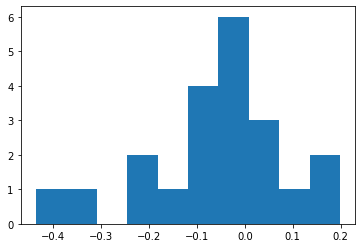

In [ ]:
differences = (
    training_data_mean_imputed.values[all_na_values]
    - training_data_knn_imputed.values[all_na_values]
)
plt.hist(differences);

We can conclude that the differences between the methods are not significant, the mode is close to zero, for most of the missing values the two methods give very similar imputed values - more than half of the values are in the range [-0.1,0.1]

Now let's look at how the difference is distributed for each column using a boxplot and a swarm plot.


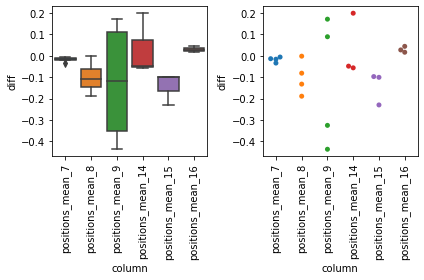

In [ ]:
na_rows, na_columns = np.where(all_na_values)
dataframe_differences_columns = pd.DataFrame(
    {'diff': differences, 'column': training_features.columns[na_columns]}
)

fig, axs = plt.subplots(ncols=2)

axis = sns.boxplot(
    x='column', data=dataframe_differences_columns, y='diff', ax=axs[0]
)
axis.set_xticklabels(axis.get_xticklabels(), rotation=90);

axis = sns.swarmplot(
    x='column', data=dataframe_differences_columns, y='diff', ax=axs[1]
)
axis.set_xticklabels(axis.get_xticklabels(), rotation=90);

fig.tight_layout()

When comparing the imputed values between the 'mean' and 'KNN' approaches, we see that they produce very similar values for columns `positions_mean_7` and `positions_mean_16` but larger differences by varying degrees for the other columns. The largest (absolute) deviance is for `positions_mean_9`.


Based on this it is likely that we may need to employ different imputation techniques depending on the column/feature.

For now, however, let's use KNN imputation and make sure that after the imputation there are no more missing values in our dataset. We will bring these three different methods into Task 2 of the project.


In [ ]:
# Let's create a pipeline function that uses the KNN imputation
def pipeline_missing_values(df, method = "knn"):
  df = df.copy()
  
  columns_null_sum = df.isnull().sum()
  columns_with_nulls = columns_null_sum[columns_null_sum > 0]

  if method == "knn":
    df[columns_with_nulls.index] = impute_knn(df[columns_with_nulls.index])
  elif method == "mean":
    df[columns_with_nulls.index] = impute_mean(df[columns_with_nulls.index])
  else:
    raise f"Unknown method {method}"

  assert df.isnull().sum().sum() == 0

  return df

### Scaling
First we will take a look at how the data looks by feature/column. While the dataset contains a lot of features, we can use a boxplot to get an overview understanding of how the different columns compare.

Let's make a boxplot for every feature to get an overview of how they all relate in terms of range & centre. No need to have labels for the feature names, we just want to show all of them in one plot.

([<matplotlib.axis.XTick at 0x7fee069e5290>], [Text(0, 0, '')])

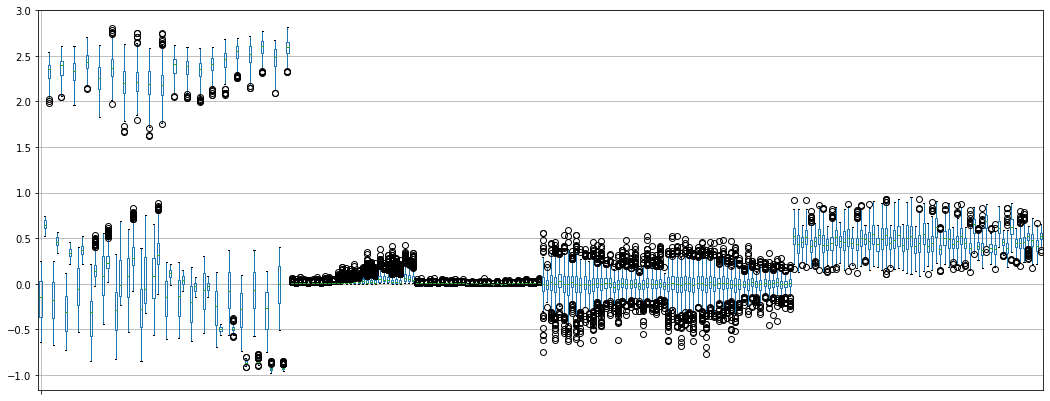

In [ ]:
training_features.boxplot(figsize=(18, 7))
plt.xticks([1], [''])

The columns are clearly not all scaled to the same range and they have different means. As such a scaler that centers the mean and normalizes (scale to the variance) may be suitable. Let's use scikit's `StandardScaler` for this.

The `StandardScaler`normalizes the data so that the mean becomes zero, and the variance one, i.e. the scaled dataset follows a *standard* normal distribution.

In [ ]:
def pipeline_scale(dataframe):
    scaler = preprocessing.StandardScaler()
    scaled_values = scaler.fit_transform(dataframe.values)
    return pd.DataFrame(scaled_values)


training_features_scaled = pipeline_scale(training_features)
training_features_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,-1.323633,1.421746,0.733025,-1.232600,1.399904,0.822277,-1.422333,1.259873,0.852019,-1.153361,...,-0.970529,0.275952,1.047194,-1.135466,0.769486,0.395003,-0.513685,0.020178,2.181665,-1.544711
1,1.003039,0.078953,0.794440,1.093898,-0.102009,0.757567,0.931582,0.171022,1.105739,0.933965,...,0.047047,-0.367940,-1.823802,1.842487,-0.235120,-1.990480,1.426960,-0.876203,-2.053768,1.825020
2,0.764166,-0.293088,-0.930321,0.915639,-0.371414,-0.985672,0.729450,0.030405,-0.094153,0.850991,...,1.837917,0.579975,-0.791318,0.629031,1.002887,0.942327,-1.474741,0.680542,0.412169,-0.811236
3,0.647555,0.376563,1.137173,0.735317,0.386874,0.780659,0.509463,0.331900,1.450155,0.662231,...,0.045200,0.254384,0.884029,-0.850038,-0.147232,-0.450141,0.702284,0.228297,1.694685,-1.276755
4,1.063069,-0.051572,0.467238,1.133087,-0.178730,0.337967,0.992393,0.077691,0.387438,1.132799,...,0.783348,-1.331643,0.485131,0.432586,-0.583229,-0.954479,1.125046,-0.296817,1.861857,-1.176475


Looks good, i.e. the mean is about 0 and the standard deviation is around 1. All the columns have now been scaled. Let's rerun the boxplot.

([<matplotlib.axis.XTick at 0x7fee06e0a610>], [Text(0, 0, '')])

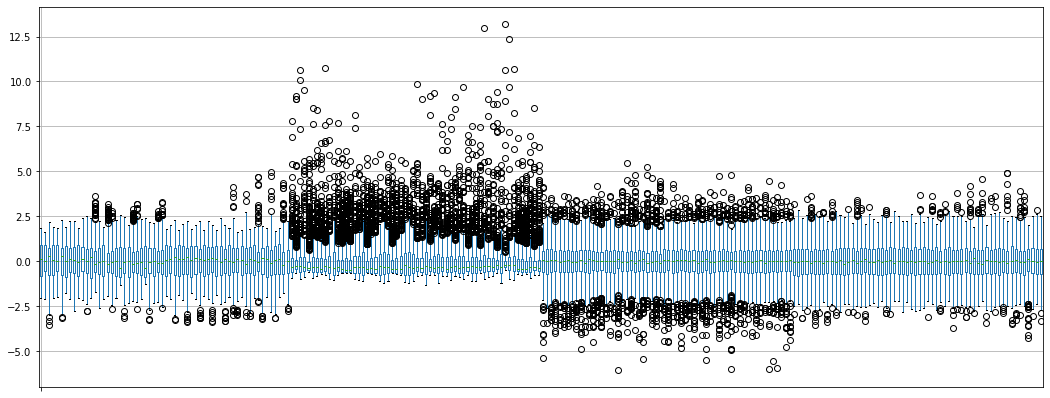

In [ ]:
training_features_scaled.boxplot(figsize=(18, 7))
plt.xticks([1], [''])

## Pipeline

In the Methods section above we have defined the pipeline methods needed for handling outliers, missing data and scaling. Let's put them all together.

([<matplotlib.axis.XTick at 0x7fee056e8290>], [Text(0, 0, '')])

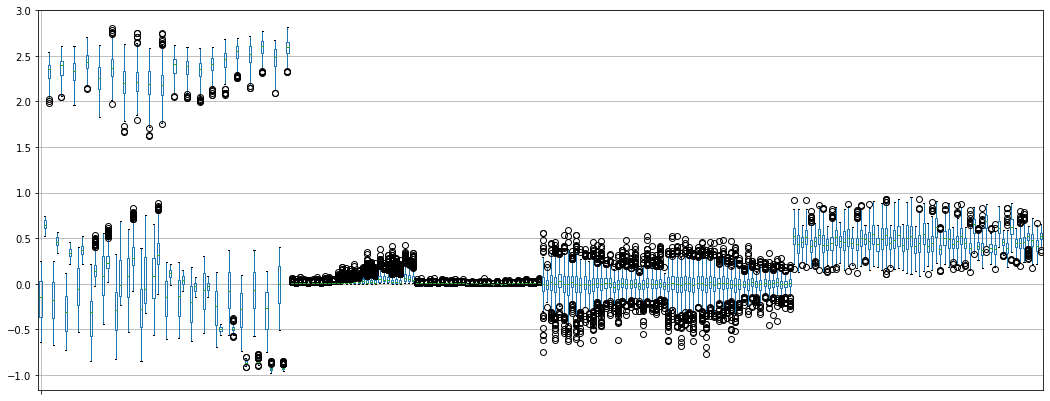

In [ ]:
# Load the data
training_features, training_labels, training_codes, test_features, test_labels = load_data()

# Plot before pipeline
training_features.boxplot(figsize=(18, 7))
plt.xticks([1], [''])

([<matplotlib.axis.XTick at 0x7fee03f23c10>], [Text(0, 0, '')])

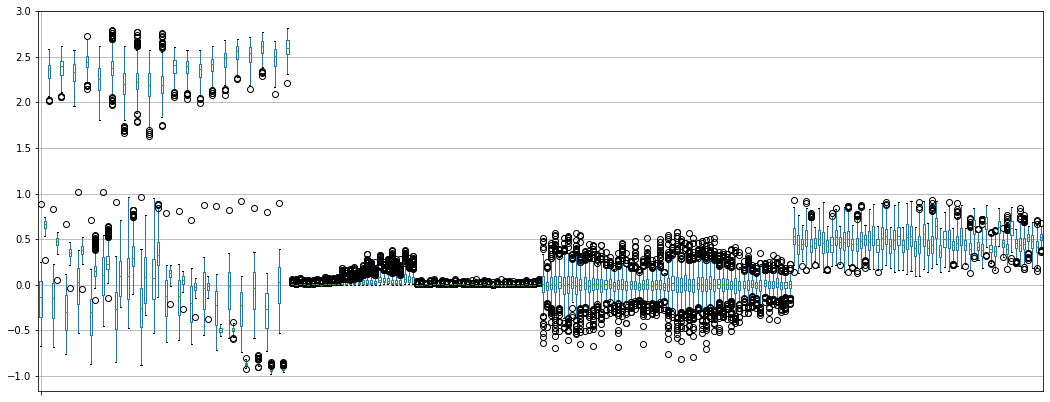

In [ ]:
test_features.boxplot(figsize=(18, 7))
plt.xticks([1], [''])

Run the pipeline and rerun the boxplot on the resulting dataset

([<matplotlib.axis.XTick at 0x7fee0275d890>], [Text(0, 0, '')])

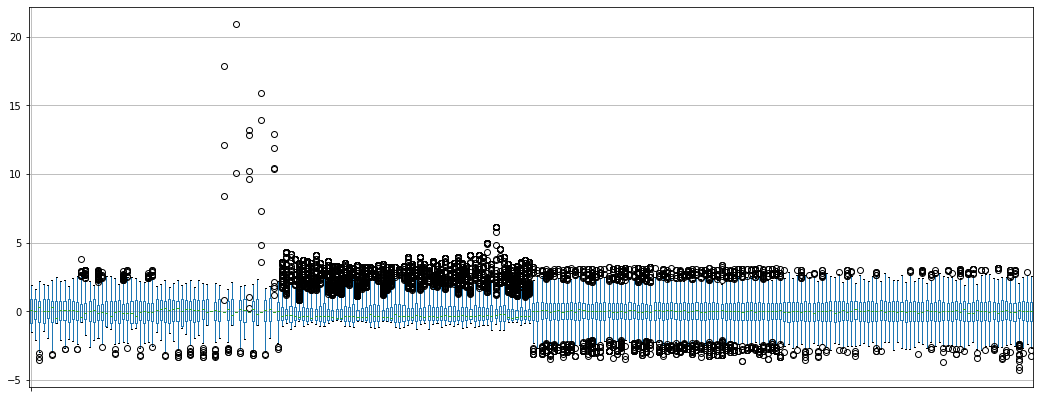

In [ ]:
def run_data_pipeline(features, std_cap = 3, impute_method = "knn"):
  df = pipeline_outliers(features, std_cap=std_cap)
  df = pipeline_missing_values(df, method = impute_method)
  df = pipeline_scale(df)

  return df

train_df = run_data_pipeline(training_features)
train_df.boxplot(figsize=(18, 7))
plt.xticks([1], [''])

([<matplotlib.axis.XTick at 0x7fee00e50fd0>], [Text(0, 0, '')])

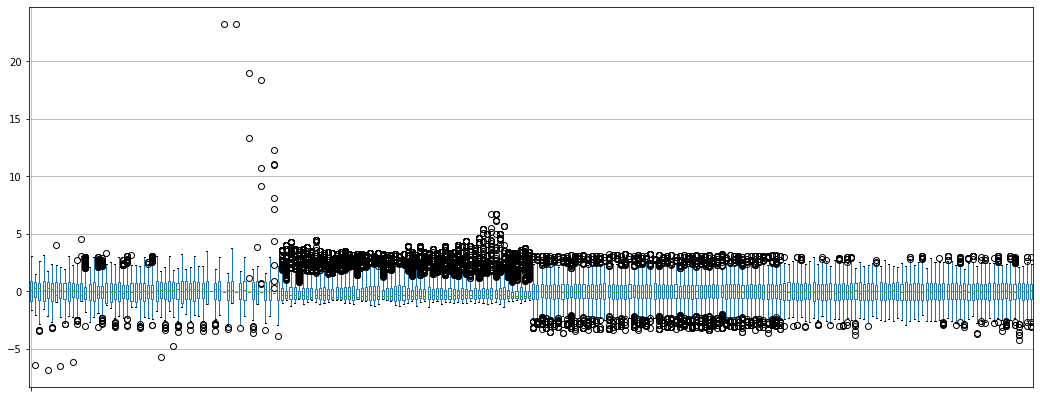

In [ ]:
test_df = run_data_pipeline(test_features)

test_df.boxplot(figsize=(18, 7))
plt.xticks([1], [''])

#Task 2

## Model selection
All avaliable classifiers from sklearn are imported along with classifications metrics for evaluation.

In [ ]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# import every avaliable classifier in sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

# import classifications metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

###Training and evaluation on the training data set

We start by creating a function that trains and evaluates a model for each of the selected classifiers with default hyperparameters on a test/train split of the training data.

In [ ]:
def evaluate_all_classifiers(X_train, X_test, y_train, y_test):
    classifiers = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        KNeighborsClassifier(),
        GaussianNB(),
        GradientBoostingClassifier(),
        AdaBoostClassifier(),
        BaggingClassifier(),
        ExtraTreesClassifier(),
        MLPClassifier(),
        # use dummy classifier to get a baseline
        DummyClassifier(strategy="most_frequent")
    ]

    # initialize a dataframe to store the results
    df_results_all = pd.DataFrame(columns=["classifier", "train_accuracy", "test_accuracy", "train_f1", "test_f1", "train_precision", "test_precision", "train_recall", "test_recall"])

    for clf in classifiers:
        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
        print("Training")
        print(f"Classifier: {clf.__class__.__name__}")

        # save the evaluation results in a dataframe
        df_results = pd.DataFrame({"classifier": [clf.__class__.__name__],
                                    "train_accuracy": [accuracy_score(y_train, y_train_pred)],
                                        "test_accuracy": [accuracy_score(y_test, y_test_pred)],
                                        "train_f1": [f1_score(y_train, y_train_pred, average='weighted')],
                                        "test_f1": [f1_score(y_test, y_test_pred, average='weighted')],
                                        "train_precision": [precision_score(y_train, y_train_pred, average='weighted')],
                                        "test_precision": [precision_score(y_test, y_test_pred, average='weighted')],
                                        "train_recall": [recall_score(y_train, y_train_pred, average='weighted')],
                                        "test_recall": [recall_score(y_test, y_test_pred, average='weighted')],
                                        })
        # append the results to the dataframe
        df_results_all = df_results_all.append(df_results, ignore_index=True)

    return df_results_all

The training data with our default preprocessing is split into training and test sets with an 80/20 split to avoid overfitting the models towards the final testing data.

In [ ]:
#import train_test_split
from sklearn.model_selection import train_test_split
X = train_df
y = training_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Traning data set shape before split: {train_df.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Traning data set shape before split: (540, 240)
X_train shape: (432, 240)
X_test shape: (108, 240)


The models are then evaluated on the split data:

In [ ]:
results_default = evaluate_all_classifiers(X_train, X_test, y_train, y_test)

Training
Classifier: LogisticRegression
Training
Classifier: DecisionTreeClassifier
Training
Classifier: RandomForestClassifier
Training
Classifier: SVC
Training
Classifier: KNeighborsClassifier
Training
Classifier: GaussianNB
Training
Classifier: GradientBoostingClassifier
Training
Classifier: AdaBoostClassifier
Training
Classifier: BaggingClassifier
Training
Classifier: ExtraTreesClassifier
Training
Classifier: MLPClassifier
Training
Classifier: DummyClassifier


In [ ]:
results_default

,classifier,train_accuracy,test_accuracy,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall
0,LogisticRegression,1.000000,0.712963,1.000000,0.716740,1.000000,0.806481,1.000000,0.712963
1,DecisionTreeClassifier,1.000000,0.537037,1.000000,0.530968,1.000000,0.590351,1.000000,0.537037
2,RandomForestClassifier,1.000000,0.759259,1.000000,0.755833,1.000000,0.863911,1.000000,0.759259
3,SVC,0.979167,0.601852,0.978828,0.606083,0.981381,0.737140,0.979167,0.601852
4,KNeighborsClassifier,0.738426,0.388889,0.730351,0.371366,0.789512,0.534796,0.738426,0.388889
5,GaussianNB,0.949074,0.657407,0.945415,0.662033,0.955393,0.778660,0.949074,0.657407
6,GradientBoostingClassifier,1.000000,0.592593,1.000000,0.588262,1.000000,0.662912,1.000000,0.592593
7,AdaBoostClassifier,0.185185,0.166667,0.108956,0.112470,0.175501,0.113496,0.185185,0.166667
8,BaggingClassifier,0.993056,0.648148,0.992902,0.644877,0.993479,0.719290,0.993056,0.648148
9,ExtraTreesClassifier,1.000000,0.759259,1.000000,0.759420,1.000000,0.864815,1.000000,0.759259


The models are evaluated again with different preprocessing parameters (higher cap for outlier capping and mean as imputation method insetad)

In [ ]:
train_df = run_data_pipeline(training_features, std_cap = 6, impute_method="mean")
test_df = run_data_pipeline(test_features, std_cap = 6, impute_method="mean")

X = train_df
y = training_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results_cap_mean = evaluate_all_classifiers(X_train, X_test, y_train, y_test)

Training
Classifier: LogisticRegression
Training
Classifier: DecisionTreeClassifier
Training
Classifier: RandomForestClassifier
Training
Classifier: SVC
Training
Classifier: KNeighborsClassifier
Training
Classifier: GaussianNB
Training
Classifier: GradientBoostingClassifier
Training
Classifier: AdaBoostClassifier
Training
Classifier: BaggingClassifier
Training
Classifier: ExtraTreesClassifier
Training
Classifier: MLPClassifier
Training
Classifier: DummyClassifier


In [ ]:
results_cap_mean

,classifier,train_accuracy,test_accuracy,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall
0,LogisticRegression,1.000000,0.740741,1.000000,0.746833,1.000000,0.835362,1.000000,0.740741
1,DecisionTreeClassifier,1.000000,0.555556,1.000000,0.546924,1.000000,0.635995,1.000000,0.555556
2,RandomForestClassifier,1.000000,0.824074,1.000000,0.818515,1.000000,0.886596,1.000000,0.824074
3,SVC,0.981481,0.592593,0.981332,0.596478,0.983223,0.720928,0.981481,0.592593
4,KNeighborsClassifier,0.738426,0.379630,0.728063,0.345032,0.794535,0.386974,0.738426,0.379630
5,GaussianNB,0.949074,0.675926,0.946706,0.673301,0.952031,0.774228,0.949074,0.675926
6,GradientBoostingClassifier,1.000000,0.592593,1.000000,0.580413,1.000000,0.648093,1.000000,0.592593
7,AdaBoostClassifier,0.203704,0.157407,0.123673,0.115759,0.209366,0.111395,0.203704,0.157407
8,BaggingClassifier,0.993056,0.620370,0.993014,0.596732,0.993455,0.651569,0.993056,0.620370
9,ExtraTreesClassifier,1.000000,0.787037,1.000000,0.780862,1.000000,0.861883,1.000000,0.787037


At least with the default parameters for the Random Forest, we get slightly higher result on the test set by increasing the cap and changing to mean imputation.

By capping we are reducing the amount of information in the dataset, so it makes sense that a classifier that can make use of the outlier information could potentially perform better (or increase risks of overfitting as well).

##Regularization

To reduce overfitting, the feature importance is evaluated on a `RandomForestClassifier` and reduced to 45 features in accordance with the resulting plot.

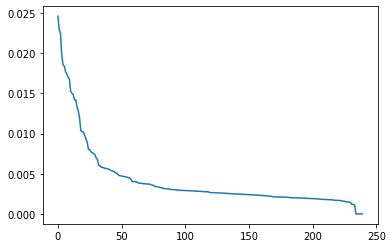

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

#df_feat_imp = pd.DataFrame(zip(train_df.columns, rf.feature_importances_), columns=["feat", "feat_imp"]).sort_values("feat_imp", ascending=False).reset_index(drop=True)#
df_feat_imp = pd.DataFrame(zip(X_train.columns, rf.feature_importances_), columns=["feat", "feat_imp"]).sort_values("feat_imp", ascending=False).reset_index(drop=True)#
df_feat_imp.feat_imp.plot()

feats_to_test = df_feat_imp.loc[:45, "feat"].values.tolist()

The models are then evaluated with the reduced feature set.

In [ ]:

X = train_df[feats_to_test].copy()
y = training_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results_reduced = evaluate_all_classifiers(X_train, X_test, y_train, y_test)

feats_to_test = df_feat_imp.loc[:45, "feat"].values.tolist()

Training
Classifier: LogisticRegression
Training
Classifier: DecisionTreeClassifier
Training
Classifier: RandomForestClassifier
Training
Classifier: SVC
Training
Classifier: KNeighborsClassifier
Training
Classifier: GaussianNB
Training
Classifier: GradientBoostingClassifier
Training
Classifier: AdaBoostClassifier
Training
Classifier: BaggingClassifier
Training
Classifier: ExtraTreesClassifier
Training
Classifier: MLPClassifier
Training
Classifier: DummyClassifier


In [ ]:
results_reduced_features

,classifier,train_accuracy,test_accuracy,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall
0,LogisticRegression,0.993056,0.759259,0.992819,0.762350,0.993530,0.824295,0.993056,0.759259
1,DecisionTreeClassifier,1.000000,0.592593,1.000000,0.590677,1.000000,0.661596,1.000000,0.592593
2,RandomForestClassifier,1.000000,0.824074,1.000000,0.822244,1.000000,0.885825,1.000000,0.824074
3,SVC,0.939815,0.740741,0.939059,0.731763,0.943738,0.823765,0.939815,0.740741
4,KNeighborsClassifier,0.861111,0.712963,0.854682,0.703453,0.882495,0.790348,0.861111,0.712963
5,GaussianNB,0.918981,0.712963,0.913904,0.699369,0.926831,0.741402,0.918981,0.712963
6,GradientBoostingClassifier,1.000000,0.638889,1.000000,0.649793,1.000000,0.716852,1.000000,0.638889
7,AdaBoostClassifier,0.162037,0.101852,0.074479,0.036503,0.098460,0.035642,0.162037,0.101852
8,BaggingClassifier,0.995370,0.777778,0.995389,0.772694,0.995773,0.827712,0.995370,0.777778
9,ExtraTreesClassifier,1.000000,0.842593,1.000000,0.843364,1.000000,0.879321,1.000000,0.842593


##"Old" code

In [ ]:
test_scores_default = {}

Random forest with default hyperparameters and the default preprocessing pipeline

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

train_df = run_data_pipeline(training_features)
test_df = run_data_pipeline(test_features)

rf = RandomForestClassifier(random_state=1234)
rf.fit(train_df, training_labels)
test_scores_default['RandomForest'] = rf.score(test_df, test_labels)

print("Score for Random Forest with default hyperparameters:")
print(f"Test Accuracy: {test_scores_default['RandomForest']}")
#print(test_scores['RandomForest'])

Score for Random Forest with default hyperparameters:
Test Accuracy: 0.8907407407407407


Still random forest, but try using different preprocessing parameters (higher cap for outlier capping and mean as imputation method insetad)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

train_df = run_data_pipeline(training_features, std_cap = 6, impute_method="mean")
test_df = run_data_pipeline(test_features, std_cap = 6, impute_method="mean")

rf = RandomForestClassifier(random_state=1234) # Fix random state for reproducible results
rf.fit(train_df, training_labels)
test_scores_default['RandomForest_cap_6_mean'] = rf.score(test_df, test_labels)

print("Score for Random Forest with default hyperparameters:")
print(f"Test Accuracy: {test_scores_default['RandomForest_cap_6_mean']}")
#print(test_scores['RandomForest'])

Score for Random Forest with default hyperparameters:
Test Accuracy: 0.8944444444444445


At least with the default parameters for the Random Forest, we get slightly higher result on the test set by increasing the cap and changing to mean imputation.

By capping we are reducing the amount of information in the dataset, so it makes sense that a classifier that can make use of the outlier information could potentially perform better (or increase risks of overfitting as well).

Optimizing hyperparameters for random forest with GridSearchCV:

In [ ]:
'''
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 120, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [8, 16, 32]
# Minimum number of samples required to split a node
min_samples_split = [8, 16, 32]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

train_df = run_data_pipeline(training_features)
test_df = run_data_pipeline(test_features)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 360 different combinations, and use all available cores
rf_grid =  GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4)
# Fit the random search model
rf_grid.fit(train_df, training_labels)
'''

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


KeyboardInterrupt: ignored

In [ ]:
rf_grid.score(test_df, test_labels)
#rf_grid.best_params_

In [ ]:
'''
{'bootstrap': False,
 'max_depth': 16,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 90}

score = 0.9055555555555556
'''

Decision tree with default parameters:

In [ ]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(train_df, training_labels)
test_scores_default['tree'] = decision_tree.score(test_df, test_labels)

print("Score for Decision Tree with default hyperparameters:")
print(f"Test Accuracy: {test_scores_default['tree']}")

MLP with default hyperparameters:

In [ ]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier()
MLP.fit(train_df, training_labels)
test_scores_default['MLP'] = MLP.score(test_df, test_labels)

print("Score for MLP with default hyperparameters:")
print(f"Test Accuracy: {test_scores_default['MLP']}")

SVM with default hyperparameters:

In [ ]:
from sklearn import svm

svm_model = svm.SVC(kernel = 'linear',gamma = 'scale', shrinking = False,)
svm_model.fit(train_df, training_labels)
test_scores_default['SVM'] = svm_model.score(test_df, test_labels)

print("Score for SVM with default hyperparameters:")
print(f"Test Accuracy: {test_scores_default['SVM']}")

kNN with default hyperparameters:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier(n_neighbors=3)
kNN.fit(train_df, training_labels)
test_scores_default['kNN'] = kNN.score(test_df, test_labels)

print("Score for kNN with default hyperparameters:")
print(f"Test Accuracy: {test_scores_default['kNN']}")

In [ ]:
print("All scores with default hyperparameters:")
print(test_scores_default)

In [ ]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# train a model with every classifier in sklearn and evaluate on both train and test set
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# import dummy classifier
from sklearn.dummy import DummyClassifier

# import classifications metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

#import train_test_split
from sklearn.model_selection import train_test_split
X = train_df
y = training_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    MLPClassifier(),
    # use dummy classifier to get a baseline
    DummyClassifier(strategy="most_frequent")
]

# initialize a dataframe to store the results
df_results_all = pd.DataFrame(columns=["classifier", "train_accuracy", "test_accuracy", "train_f1", "test_f1", "train_precision", "test_precision", "train_recall", "test_recall"])

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    print("Training")
    print(f"Classifier: {clf.__class__.__name__}")

    # save the evaluation results in a dataframe
    df_results = pd.DataFrame({"classifier": [clf.__class__.__name__],
                                 "train_accuracy": [accuracy_score(y_train, y_train_pred)],
                                    "test_accuracy": [accuracy_score(y_test, y_test_pred)],
                                    "train_f1": [f1_score(y_train, y_train_pred, average='weighted')],
                                    "test_f1": [f1_score(y_test, y_test_pred, average='weighted')],
                                    "train_precision": [precision_score(y_train, y_train_pred, average='weighted')],
                                    "test_precision": [precision_score(y_test, y_test_pred, average='weighted')],
                                    "train_recall": [recall_score(y_train, y_train_pred, average='weighted')],
                                    "test_recall": [recall_score(y_test, y_test_pred, average='weighted')],
                                    })
    # append the results to the dataframe
    df_results_all = df_results_all.append(df_results, ignore_index=True)

df_results_all

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

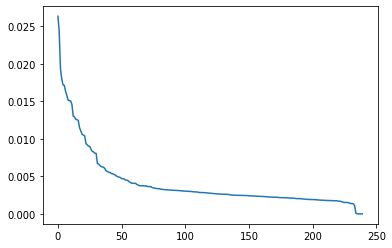

In [ ]:
df_feat_imp = pd.DataFrame(zip(train_df.columns, rf.feature_importances_), columns=["feat", "feat_imp"]).sort_values("feat_imp", ascending=False).reset_index(drop=True)#
df_feat_imp.feat_imp.plot()

In [ ]:
feats_to_test = df_feat_imp.loc[:45, "feat"].values.tolist()

X = train_df[feats_to_test].copy()
y = training_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    MLPClassifier(),
    # use dummy classifier to get a baseline
    DummyClassifier(strategy="most_frequent")
]

# initialize a dataframe to store the results
df_results_all = pd.DataFrame(columns=["classifier", "train_accuracy", "test_accuracy", "train_f1", "test_f1", "train_precision", "test_precision", "train_recall", "test_recall"])

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    print("Training")
    print(f"Classifier: {clf.__class__.__name__}")

    # save the evaluation results in a dataframe
    df_results = pd.DataFrame({"classifier": [clf.__class__.__name__],
                                 "train_accuracy": [accuracy_score(y_train, y_train_pred)],
                                    "test_accuracy": [accuracy_score(y_test, y_test_pred)],
                                    "train_f1": [f1_score(y_train, y_train_pred, average='weighted')],
                                    "test_f1": [f1_score(y_test, y_test_pred, average='weighted')],
                                    "train_precision": [precision_score(y_train, y_train_pred, average='weighted')],
                                    "test_precision": [precision_score(y_test, y_test_pred, average='weighted')],
                                    "train_recall": [recall_score(y_train, y_train_pred, average='weighted')],
                                    "test_recall": [recall_score(y_test, y_test_pred, average='weighted')],
                                    })
    # append the results to the dataframe
    df_results_all = df_results_all.append(df_results, ignore_index=True)

df_results_all

In [ ]:
train_df.head()

In [ ]:
training_codes.shape

In [ ]:
df = pd.read_csv('train-final.csv', header=None)
df.head()

In [ ]:
X_train.mean()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split


#train_df = train_df#run_data_pipeline(training_features)
#test_df = run_data_pipeline(test_features)

X = df.iloc[:, :239]
#X = train_df
#y = training_labels
#y = training_codes
y = df[241]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
mean_values = X_train.mean()
X_train = X_train.fillna(mean_values)
X_test = X_test.fillna(mean_values)

# logistic regression
logreg = LogisticRegression(C=200, penalty="l2")
rfe_lr = RFE(logreg, n_features_to_select=10, step=10)
rfe_lr = rfe_lr.fit(X_train, y_train)
#print(rfe.support_)
#print(rfe.ranking_)
print(X_train.columns[rfe_lr.support_])

# random forest
rf = RandomForestClassifier()
rfe_rf = RFE(rf, n_features_to_select=10, step=10)
rfe_rf = rfe_rf.fit(X_train, y_train)
#print(rfe.support_)
#print(rfe.ranking_)
print(X_train.columns[rfe_rf.support_])

X_train2 = rfe_lr.transform(X_train)
X_test2 = rfe_lr.transform(X_test)
logreg.fit(X_train2, y_train)
y_train_pred_lr = logreg.predict(X_train2)
y_test_pred_lr = logreg.predict(X_test2)

X_train2 = rfe_rf.transform(X_train)
X_test2 = rfe_rf.transform(X_test)
rf.fit(X_train2, y_train)
y_train_pred_rf = rf.predict(X_train2)
y_test_pred_rf = rf.predict(X_test2)

print(f"Logistic regression score: {accuracy_score(y_train, y_train_pred_lr):.2f}")
print(f"Logistic regression score: {accuracy_score(y_test, y_test_pred_lr):.2f}")
print(f"Random forest score: {accuracy_score(y_train, y_train_pred_rf):.2f}")
print(f"Random forest score: {accuracy_score(y_test, y_test_pred_rf):.2f}")


KeyError: ignored

In [ ]:
logreg.coef_.shape

In [ ]:
pd.DataFrame(zip(list(X_train.columns[(rfe_rf.support_)]), rf.feature_importances_), columns=["feat", "feat_imp"]).sort_values("feat_imp", ascending=False)

In [ ]:
'''
fig, ax = plt.subplots(ncols=1)
x = np.arange(0, len(results_all["classifier"]))

ax[0].bar(x, results_all["train_accuracy"])
ax[0].set_xticks(x)
ax[0].set_xticklabels(results_all["classifier"], rotation='vertical')

ax[1].bar(x, results_all["test_accuracy"])
ax[1].set_xticks(x)
ax[1].set_xticklabels(results_all["classifier"], rotation='vertical')

diff = results_all["train_accuracy"] - results_all["test_accuracy"]
ax[0].bar(x, diff)
ax[0].set_xticks(x)
ax[0].set_xticklabels(results_all["classifier"], rotation='vertical')


diff = results_all["train_accuracy"] - results_all["test_accuracy"]
x = np.arange(0, len(results_all["classifier"]))
plt.bar(x, diff)
plt.xticks(x, results_all["classifier"], rotation='vertical')

fig.tight_layout()
plt.show()
'''

'\nfig, ax = plt.subplots(ncols=1)\nx = np.arange(0, len(results_all["classifier"]))\n\nax[0].bar(x, results_all["train_accuracy"])\nax[0].set_xticks(x)\nax[0].set_xticklabels(results_all["classifier"], rotation=\'vertical\')\n\nax[1].bar(x, results_all["test_accuracy"])\nax[1].set_xticks(x)\nax[1].set_xticklabels(results_all["classifier"], rotation=\'vertical\')\n\ndiff = results_all["train_accuracy"] - results_all["test_accuracy"]\nax[0].bar(x, diff)\nax[0].set_xticks(x)\nax[0].set_xticklabels(results_all["classifier"], rotation=\'vertical\')\n\n\ndiff = results_all["train_accuracy"] - results_all["test_accuracy"]\nx = np.arange(0, len(results_all["classifier"]))\nplt.bar(x, diff)\nplt.xticks(x, results_all["classifier"], rotation=\'vertical\')\n\nfig.tight_layout()\nplt.show()\n'